In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import joblib
import time
np.random.seed(2)


In [2]:
def load_all(fname):
    return pickle.load(open(fname,"rb"))
def load_y(fname):
    return np.array(pickle.load(open(fname,"rb")))

In [3]:
#path = "D:/"
path = "/scratch/pbanerj6/sml-dataset/"
trainSamples = 75000
n_iter = 1000 
#n_trainSamples = [100,250,500,750,1000,1250,1500]
n_trainSamples = [100,500,1000,10000,20000,50000,75000]

In [4]:
X_train_all = load_all(path+"X_train_all_90.pkl")[:trainSamples]
X_val_all = load_all(path+"X_val_all_90.pkl")

y_train = load_y(path+"y_train.p")[:trainSamples]
y_val = load_y(path+"y_val.p")

In [5]:
from sklearn.linear_model import SGDClassifier

In [6]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'alpha':[0.0001, 0.001, 0.01],
    'epsilon':[0.1,0.3,0.5],
    'validation_fraction':[0.1,0.2]
 }

In [8]:
sgd_clf = GridSearchCV(SGDClassifier(loss='log',fit_intercept=True,n_iter=n_iter, n_jobs=-1), 
                      parameters,n_jobs=-1,cv=3, verbose=4, iid=True)

In [9]:
gridtime = time.time()
model = sgd_clf.fit(X_train_all, y_train)
print("The Total Training Time Taken : ",time.time() - gridtime)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done  49 out of  54 | elapsed: 68.2min remaining:  7.0min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 79.3min finished
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


The Total Training Time Taken :  5826.480394124985


In [10]:
model.best_score_

0.6382533333333333

In [11]:
print(model.best_params_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, model.best_params_[param_name]))

{'alpha': 0.01, 'validation_fraction': 0.1, 'epsilon': 0.1}
alpha: 0.01
epsilon: 0.1
validation_fraction: 0.1


In [12]:
pickle.dump(model,open("SGDClassifier_all_"+str(trainSamples)+"_"+str(n_iter)+".pkl",'wb'))

In [13]:
X_test_all = load_all(path+"X_test_all_90.pkl")
y_test = load_y(path+"y_test.p")

In [14]:
from scipy.stats import rankdata

def mrrs(out, labels):
#     print(out,labels)
    outputs = np.argmax(out,axis=1)
    mrr = 0.0 
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        mrr+=1/rank
    return mrr/len(labels)

def precision_at(out,labels,prank=1):
    count = 0
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        if rank <= prank:
            count+=1
    return count/len(labels)

def mrrwrapper(qid2c,qid2indexmap,preds_prob):
    labels = []
    out = []
    for qid in qid2c.keys():
        scores = []
        for ix in qid2indexmap[qid]:
            if len(scores) < 6:
                scores.append(preds_prob[ix][1])
        if len(scores) < 6:
            continue
        out.append(scores)
        labels.append(int(qid2c[qid]))
    return mrrs(np.array(out),labels),precision_at(np.array(out),labels,1),precision_at(np.array(out),labels,3)

def load_ranking(fname):
    return pickle.load(open(path+"ranking_"+fname+".p","rb"))

In [15]:
from sklearn.metrics import accuracy_score

In [16]:
valAccuracy = []
testAccuracy = []
mrrScore = []
precisionAt1 = []
precisionAt3 = []

# For each of training sample sizes
for eachTrain in n_trainSamples:
    
    # Model with best values from grid search
    bestModel = SGDClassifier(loss='log',alpha=model.best_params_['alpha'],l1_ratio=0.15, 
                              epsilon=model.best_params_['epsilon'],validation_fraction = model.best_params_['validation_fraction'],
                              n_iter_no_change=5,
                                   fit_intercept=True, n_iter=n_iter, n_jobs=-1)

    print("SampleSize:",eachTrain)
    
    stime=time.time()
    bestModel.fit(X_train_all[:eachTrain],y_train[:eachTrain])   
    print("Train Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_val = bestModel.predict(X_val_all)
    accuracy = round(accuracy_score(y_val, preds_val),4)
    valAccuracy.append(accuracy)
    print("Validation Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Validation Time:%.2f sec"%(time.time()-stime))

    stime=time.time()
    preds_test = bestModel.predict(X_test_all)
    accuracy = round(accuracy_score(y_test, preds_test),4)
    testAccuracy.append(accuracy)
    print("Test Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Test Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_test_probs = bestModel.predict_proba(X_test_all)
    qid2c,qid2indexmap = load_ranking("test")
    print (mrrwrapper(qid2c,qid2indexmap,preds_test_probs))
    mrr, pAt1, pAt3 = mrrwrapper(qid2c,qid2indexmap,preds_test_probs)
    mrrScore.append(mrr)
    print("MRR:",mrr)
    print("MRR Time:%.2f sec"%(time.time()-stime))
    
    precisionAt1.append(pAt1)
    precisionAt3.append(pAt3)
    
    #input()
print (valAccuracy)
print (testAccuracy)
print (mrrScore)
print (precisionAt1)
print (precisionAt3)

SampleSize: 100


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Train Time:1.62 sec
Validation Accuracy: 50.00%
Validation Time:0.16 sec
Test Accuracy: 50.00%
Test Time:0.15 sec
(0.4573904761904774, 0.224, 0.5633333333333334)
MRR: 0.4573904761904774
MRR Time:0.85 sec
SampleSize: 500


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Train Time:7.13 sec
Validation Accuracy: 50.07%
Validation Time:0.12 sec
Test Accuracy: 50.00%
Test Time:0.12 sec
(0.43184444444444464, 0.19333333333333333, 0.532)
MRR: 0.43184444444444464
MRR Time:0.71 sec
SampleSize: 1000


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Train Time:15.44 sec
Validation Accuracy: 49.95%
Validation Time:0.11 sec
Test Accuracy: 50.15%
Test Time:0.18 sec
(0.438711111111111, 0.20066666666666666, 0.5466666666666666)
MRR: 0.438711111111111
MRR Time:0.74 sec
SampleSize: 10000


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Train Time:152.38 sec
Validation Accuracy: 54.65%
Validation Time:0.14 sec
Test Accuracy: 53.26%
Test Time:0.25 sec
(0.5168592592592609, 0.284, 0.6646666666666666)
MRR: 0.5168592592592609
MRR Time:0.72 sec
SampleSize: 20000


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Train Time:297.63 sec
Validation Accuracy: 58.49%
Validation Time:0.12 sec
Test Accuracy: 56.81%
Test Time:0.21 sec
(0.5315238095238114, 0.2966666666666667, 0.6966666666666667)
MRR: 0.5315238095238114
MRR Time:0.91 sec
SampleSize: 50000


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Train Time:749.57 sec
Validation Accuracy: 62.47%
Validation Time:0.10 sec
Test Accuracy: 61.33%
Test Time:0.19 sec
(0.5717703703703724, 0.3426666666666667, 0.744)
MRR: 0.5717703703703724
MRR Time:0.70 sec
SampleSize: 75000


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Train Time:1113.41 sec
Validation Accuracy: 64.29%
Validation Time:0.09 sec
Test Accuracy: 64.53%
Test Time:0.15 sec
(0.5971925925925942, 0.37666666666666665, 0.7766666666666666)
MRR: 0.5971925925925942
MRR Time:0.92 sec
[0.5, 0.5007, 0.4995, 0.5465, 0.5849, 0.6247, 0.6429]
[0.5, 0.5, 0.5015, 0.5326, 0.5681, 0.6133, 0.6453]
[0.4573904761904774, 0.43184444444444464, 0.438711111111111, 0.5168592592592609, 0.5315238095238114, 0.5717703703703724, 0.5971925925925942]
[0.224, 0.19333333333333333, 0.20066666666666666, 0.284, 0.2966666666666667, 0.3426666666666667, 0.37666666666666665]
[0.5633333333333334, 0.532, 0.5466666666666666, 0.6646666666666666, 0.6966666666666667, 0.744, 0.7766666666666666]


In [17]:
def accuracyVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,testAccuracy,label='TestAccuracy vs TrainData',marker='o')
    ax.plot(n_trainSamples,valAccuracy,label='ValAccuracy vs TrainData',marker='.')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("SGDClassifier_Accuracy_all.png")
    #plt.show()

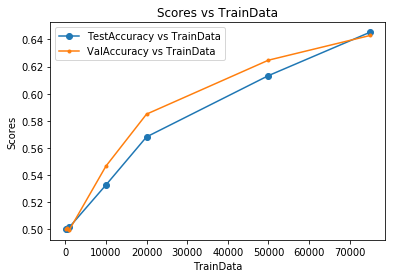

In [18]:
accuracyVisualization()

In [19]:
def mrrVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,mrrScore,label='MRR vs TrainData',marker='x')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("SGDClassifier_Mrr_all.png")
    plt.show()

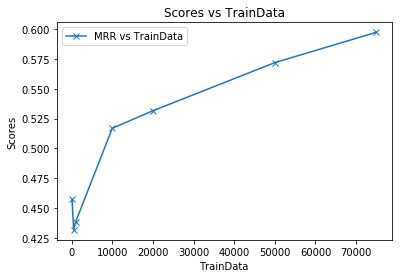

In [20]:
mrrVisualization()

In [21]:
#Precision @1 and Precision @2 Visualizations
def precisionVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,precisionAt1,label='Precision@1 vs TrainData',marker='x')
    ax.plot(n_trainSamples,precisionAt3,label='Precision@3 vs TrainData',marker='o')
    plt.title("Precision Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("SGD_Precision_all.png")
    plt.show()

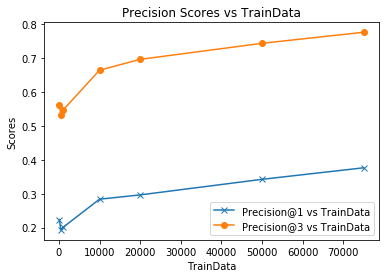

In [22]:
precisionVisualization()